In [2]:
import importlib
import os
import sys

import numpy as np
import pandas as pd
from datasets import Dataset
sys.path.append("../")

import src

importlib.reload(src)

from src.data_prep_utils import (  # noqa: E402
    conala_to_time_batches,
    load_time_sorted_conala,
)

importlib.reload(src.data_prep_utils)


from src.training import nd_inference, retraining, continual
importlib.reload(src.training)

import torch
from transformers import (
    DataCollatorForSeq2Seq,
    RobertaTokenizerFast,
    Seq2SeqTrainer,
    Seq2SeqTrainingArguments,
    T5ForConditionalGeneration,
)
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from src.processing_utils import compute_metric_with_params, prepare_hg_ds
from tqdm import tqdm
tqdm.pandas()

import seaborn as sns
import evaluate

/home/RDC/zinovyee.hub/.conda/envs/dd_spek/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt to
[nltk_data]     /home/RDC/zinovyee.hub/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
#%pip install rouge_score
#%pip install absl
#%pip install seaborn
#%pip install transformers[torch]

In [4]:
os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["WANDB_DISABLED"] = "true"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [5]:
MODEL = "CodeT5"
TRAIN_N = 330
BATCH_SIZE = 15
DECODER_LENGTH = 20
ENCODER_LENGTH = 15

TRAIN_ARGS = {
    "TRAIN_N": TRAIN_N,
    "BATCH_SIZE": BATCH_SIZE,
    "DECODER_LENGTH": DECODER_LENGTH,
    "ENCODER_LENGTH": ENCODER_LENGTH,
    "MODEL": MODEL,
    "SEQ_TRAINER_ARGS": {
        "overwrite_output_dir": True,
        "num_train_epochs": 7,
        "do_train": True,
        "do_eval": True,
        "per_device_train_batch_size": 4,
        "per_device_eval_batch_size": 4,
        "learning_rate": 5e-4,
        "warmup_steps": 100,
        "weight_decay": 0.1,
        "label_smoothing_factor": 0.1,
        "predict_with_generate": True,
        "logging_steps": 100,
        "save_total_limit": 1,
        "save_strategy": "no",
        "logging_strategy": "epoch",
        "evaluation_strategy": "epoch",
        "load_best_model_at_end": False,
    },
}

In [6]:
#df = load_time_sorted_conala("../data/raw/conala")  # noqa: PD901
#df = conala_to_time_batches(df, 30, BATCH_SIZE)  # noqa: PD901
DATE_STR = "20240327"
df = pd.read_csv(f"../data/processed/conala/{DATE_STR}/all_drifts.csv")
df["t_batch"] = df["time_batch"]

model_name="Salesforce/codet5-base-multi-sum"
tokenizer = AutoTokenizer.from_pretrained(model_name, skip_special_tokens=False)

In [7]:
def prep_for_hf(df: pd.DataFrame, batch_id: int|list, batch_name: str) -> Dataset:
    """Convert pandas dataframe to huggingface."""
    df = df.rename(columns={"snippet": "input_sequence",  # noqa: PD901
                    "intent" : "output_sequence"})
    if isinstance(batch_id, list):
        df = df.loc[df[batch_name].isin(batch_id), ["input_sequence", "output_sequence", "idx"]]  # noqa: PD901
    elif isinstance(batch_id, int):
        df = df.loc[df[batch_name]==batch_id, ["input_sequence", "output_sequence", "idx"]]  # noqa: PD901
    df = df.sample(frac=1, random_state=42)  # noqa: PD901
    return Dataset.from_pandas(df)

In [8]:
def batch_tokenize_preprocess(batch, tokenizer, max_input_length, max_output_length):

    source = batch["input_sequence"]
    target = batch["output_sequence"]

    source_tokenized = tokenizer(
        source, padding="max_length",
        truncation=True, max_length=max_input_length
    )

    target_tokenized = tokenizer(
        target, padding="max_length",
        truncation=True, max_length=max_output_length
    )

    batch = {k: v for k, v in source_tokenized.items()}

    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in label]
        for label in target_tokenized["input_ids"]
    ]

    return batch

In [9]:
COLUMN_BATCH = "sudden_batch"

train_dataset = prep_for_hf(df, 0, COLUMN_BATCH)

train_data = train_dataset.map(
        lambda batch: batch_tokenize_preprocess(
            batch,
            tokenizer=tokenizer,
            max_input_length=15,
            max_output_length=20,
        ),
        batch_size=4,
        batched=True,
        #remove_columns=train_dataset.column_names,
    )

test_dataset = prep_for_hf(df, list(range(1, df.time_batch.max()+1)), COLUMN_BATCH)

test_data = test_dataset.map(
        lambda batch: batch_tokenize_preprocess(
            batch,
            tokenizer=tokenizer,
            max_input_length=15,
            max_output_length=20,
        ),
        batch_size=4,
        batched=True,
        #remove_columns=train_dataset.column_names,
    )

In [10]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

compute_metrics = compute_metric_with_params(tokenizer)

cuda


In [11]:
TRAIN_ARGS["SEQ_TRAINER_ARGS"]["output_dir"] = 'reports/nd_infer/results'
TRAIN_ARGS["SEQ_TRAINER_ARGS"]["logging_dir"] = 'reports/nd_infer/logs'

if not os.path.exists(TRAIN_ARGS["SEQ_TRAINER_ARGS"]["logging_dir"]): 
    os.mkdir(TRAIN_ARGS["SEQ_TRAINER_ARGS"]["logging_dir"])
    
training_args = Seq2SeqTrainingArguments(
        **TRAIN_ARGS["SEQ_TRAINER_ARGS"],
    )


trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_data,
    eval_dataset=test_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
/home/RDC/zinovyee.hub/.conda/envs/dd_spek/lib/python3.11/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


In [12]:
MODEL_PATH = "reports/nd_infer/saved_model"
if not os.path.exists(MODEL_PATH): 
    os.mkdir(MODEL_PATH)

In [13]:
#trainer.train()
#trainer.save_model(MODEL_PATH)

In [14]:
def generate_summary(test_samples, model, tokenizer, encoder_max_length, decoder_max_length):

    inputs = tokenizer(
        test_samples["input_sequence"],
        padding="max_length",
        truncation=True,
        max_length=encoder_max_length,
        return_tensors="pt",
    )
    input_ids = inputs.input_ids.to(model.device)
    attention_mask = inputs.attention_mask.to(model.device)
    outputs = model.generate(input_ids, attention_mask=attention_mask, max_new_tokens=decoder_max_length)
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return outputs, output_str

In [15]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH, skip_special_tokens=False)

In [16]:
text = df.snippet.values
summaries = generate_summary(test_data, model, tokenizer, 15, 20)

df["temporal_prediction_nd"] = "USED IN TRAIN"
df.loc[df.time_batch!=0, "temporal_prediction_nd"] = summaries[1]

In [23]:
rouge = evaluate.load('rouge')

df["temporal_prediction_nd_rouge"] = -999
df["temporal_prediction_nd_rouge"] = df[df.sudden_batch!=0].progress_apply(lambda x: rouge.compute(predictions=[x["temporal_prediction_nd"]], references=[x["intent"]])["rouge1"], axis=1)

ind_av_rouge = {}
batch_rouge_calculations = {}
for t_batch in range(1, df.time_batch.max()+1):
    ind_av_rouge[t_batch] = df.loc[df.sudden_batch==t_batch, "temporal_prediction_nd_rouge"].mean()
    batch_rouge_calculations[t_batch] = rouge.compute(predictions=df.loc[df.sudden_batch==t_batch, "temporal_prediction_nd"].values, references=df.loc[df.sudden_batch==t_batch, "intent"].values)["rouge1"]

ind_av_rouge_nd = np.array(list(ind_av_rouge.values()))
batch_rouge_calculations_nd = np.array(list(batch_rouge_calculations.values()))

  0%|          | 2/2500 [00:00<03:43, 11.16it/s]INFO:absl:Using default tokenizer.
INFO:absl:Using default tokenizer.
  1%|▏         | 33/2500 [00:03<04:21,  9.44it/s]INFO:absl:Using default tokenizer.


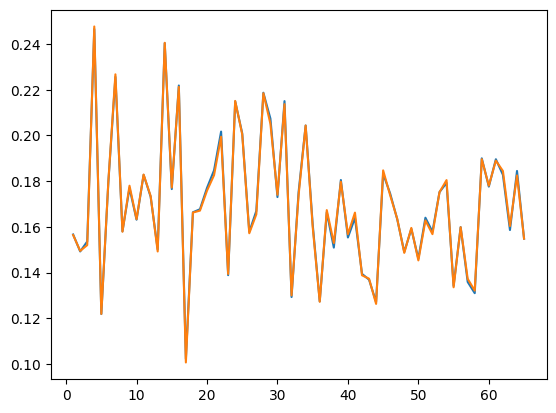

In [ ]:
import matplotlib.pyplot as plt
sns.lineplot(x=range(1, 66), y=ind_av_rouge_nd)
sns.lineplot(x=range(1, 66), y=batch_rouge_calculations_nd)
plt.savefig('reports/nd_infer/output.png')

In [ ]:
# SAVE RESULTS
import pickle
df.to_csv('reports/nd_infer/results.csv')

with open('reports/nd_infer/ind_av_rouge_nd.pickle', 'wb') as handle:
    pickle.dump(ind_av_rouge_nd, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('reports/nd_infer/batch_rouge_calculations_nd.pickle', 'wb') as handle:
    pickle.dump(batch_rouge_calculations_nd, handle, protocol=pickle.HIGHEST_PROTOCOL)